In [ ]:
! pip install pybaseball

     |████████████████████████████████| 409kB 5.7MB/s 
     |████████████████████████████████| 17.7MB 238kB/s 
     |████████████████████████████████| 296kB 46.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [ ]:
! pip install shap

     |████████████████████████████████| 327kB 6.0MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463909 sha256=170211ea5fba09686f010167af6da37d2f15cabb55f8276d9c9c0b152662ea08
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
#imports
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Data Processing - Injury Data

In [ ]:
# Injury data from Spotrac
injury = pd.read_csv('InjuryData2020.csv')

In [ ]:
# Removed any pitchers with qualified start IP (Min 100) that were also injured at some point
injury = injury.drop_duplicates(subset='PLAYER',keep="first")

In [ ]:
# Split name to pass to playerid_lookup
injury[['first_name','last_name']] = injury['PLAYER'].loc[injury['PLAYER'].str.split().str.len() == 2].str.split(expand=True)

In [ ]:
# Inspect the format of the player_lookup() function
playerid_lookup("sale","chris")

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,sale,chris,519242,salec001,salech01,10603,2010.0,2019.0


In [ ]:
# Inspect the format of the statcast_pitcher() function
kershaw = statcast_pitcher('2019-03-01', '2019-10-01', 519242)
kershaw[0:5]

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,CH,2019-08-13,89.8,3.19,4.92,Chris Sale,596019,519242,double,hit_into_play_score,NaN,NaN,NaN,NaN,8.0,Francisco Lindor doubles (28) on a line drive ...,R,R,L,CLE,BOS,X,7.0,line_drive,0,1,2019,1.4,-0.1,-0.09,1.46,547379.0,656185.0,NaN,2,7,Bot,55.97,110.57,NaN,...,-32.963668,3.29,1.55,119.0,107.8,5.0,89.1,1983.0,6.0,565379,519242,506702,519048,593523,646240,593428,643217,598265,605141,54.53,0.638,0.583,1.25,1.0,1.0,1.0,4.0,64,2,Changeup,3,6,3,6,6,3,3,6,Standard,Standard
1,SL,2019-08-13,81.3,3.22,5.28,Chris Sale,596019,519242,NaN,called_strike,NaN,NaN,NaN,NaN,12.0,NaN,R,R,L,CLE,BOS,S,NaN,NaN,0,0,2019,-1.1,-0.4,0.89,3.10,547379.0,656185.0,NaN,2,7,Bot,NaN,NaN,NaN,...,-36.435530,3.46,1.59,NaN,NaN,NaN,79.8,2624.0,5.4,565379,519242,506702,519048,593523,646240,593428,643217,598265,605141,55.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,1,Slider,3,6,3,6,6,3,3,6,Standard,Standard
2,SL,2019-08-13,83.1,3.04,5.25,Chris Sale,571980,519242,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,Tyler Naquin pops out to first baseman Mitch M...,R,L,L,CLE,BOS,X,3.0,popup,2,2,2019,-1.2,-0.5,-0.15,2.29,547379.0,656185.0,NaN,1,7,Bot,167.72,156.28,NaN,...,-37.153370,3.41,1.62,146.0,72.5,62.0,82.8,2636.0,6.1,565379,519242,506702,519048,593523,646240,593428,643217,598265,605141,54.38,0.015,0.013,0.00,1.0,0.0,0.0,3.0,63,5,Slider,3,6,3,6,6,3,3,6,Standard,Standard
3,FF,2019-08-13,96.6,3.03,5.52,Chris Sale,571980,519242,NaN,swinging_strike,NaN,NaN,NaN,NaN,2.0,NaN,R,L,L,CLE,BOS,S,NaN,NaN,2,1,2019,0.9,1.0,0.00,3.19,547379.0,656185.0,NaN,1,7,Bot,NaN,NaN,NaN,...,-18.563703,3.41,1.62,NaN,NaN,NaN,96.9,2422.0,6.5,565379,519242,506702,519048,593523,646240,593428,643217,598265,605141,53.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,4,4-Seam Fastball,3,6,3,6,6,3,3,6,Standard,Standard
4,FF,2019-08-13,95.7,3.13,5.21,Chris Sale,571980,519242,NaN,called_strike,NaN,NaN,NaN,NaN,1.0,NaN,R,L,L,CLE,BOS,S,NaN,NaN,2,0,2019,1.1,1.0,-0.57,2.91,547379.0,656185.0,NaN,1,7,Bot,NaN,NaN,NaN,...,-19.195588,3.33,1.53,NaN,NaN,NaN,95.8,2525.0,6.6,565379,519242,506702,519048,593523,646240,593428,643217,598265,605141,53.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,3,4-Seam Fastball,3,6,3,6,6,3,3,6,Standard,Standard


In [ ]:
# Find all mlbam ids for players in injury dataframe
lookup = []
for i, row in injury.iterrows():
  try:
    lookup.append(playerid_lookup(row['last_name'], row['first_name']).values.tolist())
  except:
    pass

Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering 

In [ ]:
# Transform player_id lookup back to 2d data
lookup = [e for sl in lookup for e in sl]

In [ ]:
# Convert player_id data to dataframe
lookupDat = pd.DataFrame(lookup, columns=['last_name','first_name','key_mlbam','key_retro','key_bbref','key_fangraphs','mlb_played_first','mlb_played_last'])

In [ ]:
# Preparing injury data for merge with player id
injury['first_name'] = injury['first_name'].str.lower()
injury['last_name'] = injury['last_name'].str.lower()

In [ ]:
# Merge Injury data with player_id lookup data
injury_lookup = injury.merge(lookupDat, on=['first_name','last_name'])

In [ ]:
injury_lookup = pd.DataFrame(injury_lookup)
injury_lookup

,PLAYER,TEAM,INJURY1,INJURY2,STATUS,DATE1,DATE2,DAYS,CASH EARNED,first_name,last_name,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,Julian Merryweather,TOR,NaN,Elbow,10-day,NaN,9/21 - 9/27,7.0,"$21,805",julian,merryweather,657240,merrj001,merryju01,-1,2020.0,2020.0
1,Cole Hamels,ATL,NaN,Shoulder,60-day,NaN,9/18 - 9/27,66.0,"$6,414,364",cole,hamels,430935,hamec001,hamelco01,4972,2006.0,2020.0
2,Dakota Hudson,STL,NaN,Elbow,60-day,NaN,9/18 - 9/27,10.0,"$32,090",dakota,hudson,641712,hudsd002,hudsoda02,19206,2018.0,2020.0
3,Brad Peacock,HOU,NaN,Shoulder,10-day,NaN,9/18 - 9/27,55.0,"$1,159,150",brad,peacock,502748,peacb001,peacobr01,5401,2011.0,2020.0
4,Jacob Waguespack,TOR,NaN,Back,10-day,NaN,9/17 - 9/27,11.0,"$34,265",jacob,waguespack,621097,waguj001,wagueja01,18318,2019.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Jordan Lyles,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,jordan,lyles,543475,lylej001,lylesjo01,7593,2011.0,2020.0
118,Erick Fedde,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,erick,fedde,607200,fedde001,feddeer01,17425,2017.0,2020.0
119,Trevor Williams,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,trevor,williams,592866,willt002,willitr01,16977,2016.0,2020.0
120,Robbie Ray,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,robbie,ray,592662,ray-r002,rayro02,11486,2014.0,2020.0


In [ ]:
# Fix date column in injury data to have the proper year
injury_lookup['DATE1_NEW'] = injury_lookup['DATE1'].str.split('-').str[0].str.strip() + "/2020"
injury_lookup['DATE2_NEW'] = injury_lookup['DATE2'].str.split('-').str[0].str.strip() + "/2020"
injury_lookup

,PLAYER,TEAM,INJURY1,INJURY2,STATUS,DATE1,DATE2,DAYS,CASH EARNED,first_name,last_name,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,DATE1_NEW,DATE2_NEW
0,Julian Merryweather,TOR,NaN,Elbow,10-day,NaN,9/21 - 9/27,7.0,"$21,805",julian,merryweather,657240,merrj001,merryju01,-1,2020.0,2020.0,NaN,9/21/2020
1,Cole Hamels,ATL,NaN,Shoulder,60-day,NaN,9/18 - 9/27,66.0,"$6,414,364",cole,hamels,430935,hamec001,hamelco01,4972,2006.0,2020.0,NaN,9/18/2020
2,Dakota Hudson,STL,NaN,Elbow,60-day,NaN,9/18 - 9/27,10.0,"$32,090",dakota,hudson,641712,hudsd002,hudsoda02,19206,2018.0,2020.0,NaN,9/18/2020
3,Brad Peacock,HOU,NaN,Shoulder,10-day,NaN,9/18 - 9/27,55.0,"$1,159,150",brad,peacock,502748,peacb001,peacobr01,5401,2011.0,2020.0,NaN,9/18/2020
4,Jacob Waguespack,TOR,NaN,Back,10-day,NaN,9/17 - 9/27,11.0,"$34,265",jacob,waguespack,621097,waguj001,wagueja01,18318,2019.0,2020.0,NaN,9/17/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Jordan Lyles,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,jordan,lyles,543475,lylej001,lylesjo01,7593,2011.0,2020.0,NaN,NaN
118,Erick Fedde,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,erick,fedde,607200,fedde001,feddeer01,17425,2017.0,2020.0,NaN,NaN
119,Trevor Williams,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,trevor,williams,592866,willt002,willitr01,16977,2016.0,2020.0,NaN,NaN
120,Robbie Ray,NaN,NaN,Healthy,NaN,NaN,NaN,NaN,NaN,robbie,ray,592662,ray-r002,rayro02,11486,2014.0,2020.0,NaN,NaN


In [ ]:
# Save the current year injury data, repeat for all seasons
injury_lookup.to_csv("injury_lookup2020.csv")

Read in Cleaned Injury Data

In [ ]:
# Injury data from Spotrac - read in the files created after completing the above steps - this is the final injury data
injury15 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2015.csv')
injury16 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2016.csv')
injury17 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2017.csv')
injury18 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2018.csv')
injury19 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2019.csv')
injury20 = pd.read_csv('C:/Users/drewb/Desktop/340/injury_lookup2020.csv')

# Append all files together
combined_injury = injury15.append(injury16).append(injury17).append(injury18).append(injury19).append(injury20)
# Removed any pitchers with qualified start IP (Min 100) that were also injured at some point
injury = combined_injury.drop_duplicates(subset=['PLAYER', 'Year'],keep="first")
injury_lookup = injury
injury_lookup.to_csv("test_injuries.csv")

Data Processing - Adding Statcast Data to Injury Data

In [ ]:
# Define percentage change function for future use
def calcPercChange(df, variable_name):
    var1 = variable_name + "_x"
    var2 = variable_name + "_y"
    return (df[var1] - df[var2])/df[var2]

In [ ]:
# Function returns a data frame of pitcher stats for the selected player and season
def getPitcherStats(pitcher_id, last_name, first_name, season):
    start_date = str(season) + '-03-01'
    end_date = str(season) + '-11-01'
    data = statcast_pitcher(start_date,end_date, pitcher_id)
    #sort values to get them all in order
    data['game_date'] = pd.to_datetime(data['game_date'])
    data.sort_values(by=['game_date', 'at_bat_number', 'pitch_number'], ascending = ['True', 'True', 'True'])
    
    
    # summation variables for pitch count #####################################################
    pitchCount = data[['game_date', 'pitch_type']].groupby(['game_date'], as_index = False).agg('count')
    pitchCount.columns = ['game_date', 'game_pitch_count']
    pitchCount['season_pitch_count'] = pitchCount['game_pitch_count'].cumsum()
    
    # add all variables we want the average of here ############################################
    byGameAverages = data[['game_date', 'pitch_type', 'release_speed', 'release_pos_x', 'release_spin_rate', 'release_extension','zone','pfx_x','pfx_z','plate_x','plate_z']].groupby(['game_date','pitch_type'], as_index=False).agg('mean')
    
    # calculate the averages by game and pitch type for each stat ##############################
    byGame2_release_speed = byGameAverages.pivot(index="game_date",columns="pitch_type",values="release_speed").reset_index().add_prefix('release_speed_')

    byGame2_release_pos_x = byGameAverages.pivot(index="game_date",columns="pitch_type",values="release_pos_x").reset_index().add_prefix('release_pos_x_')

    byGame2_release_spin_rate = byGameAverages.pivot(index="game_date",columns="pitch_type",values="release_spin_rate").reset_index().add_prefix('release_spin_rate_')

    byGame2_release_extension = byGameAverages.pivot(index="game_date",columns="pitch_type",values="release_extension").reset_index().add_prefix('release_extension_')
    byGame2_release_extension
    
    ####################################

    #combine all variables to get our wide data set for modeling
    combined = byGame2_release_speed.merge(byGame2_release_pos_x, left_on='release_speed_game_date', right_on='release_pos_x_game_date')
    combined = combined.merge(byGame2_release_spin_rate, left_on='release_speed_game_date', right_on='release_spin_rate_game_date')
    combined = combined.merge(byGame2_release_extension, left_on='release_speed_game_date', right_on='release_extension_game_date')
    
    #fill NA values with average for that pitch ################################
    combined = combined.fillna(combined.mean())
    
    # rolling average of last 5 starts ##########################################
    combined = combined.drop(['release_pos_x_game_date', 'release_spin_rate_game_date', 'release_extension_game_date'], axis=1)
    rolling_averages = combined.rolling(5, 1, on='release_speed_game_date').mean()
    #print(rolling_averages)
    
    # join combined and rolling averages ########################################
    
    merged = combined.merge(rolling_averages, left_on='release_speed_game_date', right_on='release_speed_game_date')
    #print(merged)
    
    # create new table for final variables ####################################
    final = pd.DataFrame()
    
    final['game_date'] = merged['release_speed_game_date']
    final['Season'] = season
    final['player_name'] = first_name + " " + last_name
    
    final['game_pitch_count'] = pitchCount['game_pitch_count']
    final['season_pitch_count'] = pitchCount['season_pitch_count']
    final['key_mlbam'] = pitcher_id
    final['raw_speed'] = byGameAverages['release_speed']
    final['raw_spin'] = byGameAverages['release_spin_rate']
    final['pitch_zone'] = byGameAverages['zone']
    final['horz_move'] = byGameAverages['pfx_x']
    final['vert_move'] = byGameAverages['pfx_z']
    final['horz_pos_catch'] = byGameAverages['plate_x']
    final['vert_pos_catch'] = byGameAverages['plate_z']
    
    #calculate percentage change variables
    final['release_speed_FF'] = calcPercChange(merged, 'release_speed_FF')
    final['release_pos_x_FF'] = calcPercChange(merged, 'release_pos_x_FF')
    
    return final
    



In [ ]:
# Select the necessary injury data columns
test_injuries = injury_lookup[['DATE1_NEW', 'DATE2_NEW', 'first_name', 'last_name', 'key_mlbam','Year']]
test_injuries

,DATE1_NEW,DATE2_NEW,first_name,last_name,key_mlbam
0,6/6/2019,9/16/2019,dylan,covey,592229
1,NaN,9/14/2019,lucas,giolito,608337
2,NaN,9/1/2019,kyle,gibson,502043
3,5/21/2019,8/31/2019,collin,mchugh,543521
4,6/28/2019,8/28/2019,brad,peacock,502748
...,...,...,...,...,...
159,NaN,NaN,ryan,yarbrough,642232
160,NaN,NaN,gabriel,ynoa,593679
161,NaN,NaN,trevor,cahill,502239
162,NaN,NaN,tommy,milone,543548


In [ ]:
# Gather data for players in injury data frame and make master data frame
master_df = pd.DataFrame()

for index, row in test_injuries.iterrows():
    #use try and except to deal with errors 
    try:
      temp_table = getPitcherStats(row['key_mlbam'], row['last_name'], row['first_name'], row['Year'])
      master_df = master_df.append(temp_table, ignore_index=True)
    except:
      print(row['first_name'], row['last_name'], row['key_mlbam'], row['Year'])
      continue

master_df

Gathering Player Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
zach davies 605200
Gathering Player Data
Gathering Player Data
Gathering Player Data
ryan borucki 621366
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
andrew heaney 571760
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
brian johnson 116566
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player 

,game_date,player_name,game_pitch_count,season_pitch_count,key_mlbam,raw_speed,raw_spin,pitch_zone,horz_move,vert_move,horz_pos_catch,vert_pos_catch,release_speed_FF,release_pos_x_FF
0,2019-03-28,dylan covey,17,17,592229,92.400000,2185.333333,3.000000,0.400000,0.556667,-0.066667,2.793333,0.000000,-0.000000
1,2019-04-01,dylan covey,6,23,592229,95.378571,2104.142857,8.214286,-1.063571,1.060714,-0.064286,2.217857,0.000000,-0.000000
2,2019-05-05,dylan covey,76,99,592229,95.883333,2090.166667,10.500000,-1.090000,1.198333,-0.620000,3.030000,0.000396,-0.015983
3,2019-05-10,dylan covey,83,182,592229,87.043750,1372.250000,11.375000,-0.787500,0.427500,0.400625,1.008750,-0.007203,0.135597
4,2019-05-16,dylan covey,84,266,592229,85.000000,2371.000000,14.000000,0.455000,-0.340000,1.585000,1.535000,0.001761,-0.030282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,2019-09-03,jalen beeks,34,1717,656222,76.609091,2742.000000,10.545455,-1.264545,-1.218182,-0.455455,1.813636,0.016918,-0.060579
4228,2019-09-11,jalen beeks,38,1755,656222,85.885714,2305.142857,12.714286,0.098571,0.512857,-1.251429,1.548571,0.007766,-0.312775
4229,2019-09-13,jalen beeks,15,1770,656222,93.079310,2075.827586,9.034483,0.593448,1.466897,-0.523103,2.261724,0.006152,-0.222654
4230,2019-09-22,jalen beeks,20,1790,656222,86.658333,1873.375000,9.375000,1.304583,0.567917,0.329583,2.209583,0.001680,0.597771


In [ ]:
# Save CSV so you don't have to run each time - can now start from this cell block by reading in the saved injury data and the statcast stats
#master_df.to_csv('full_master_statcast.csv')
master_df = pd.read_csv("full_master_statcast.csv")
test_injuries = pd.read_csv("test_injuries.csv")

In [ ]:
# Create datetime data types and add indicator variables
master_df = master_df.merge(test_injuries, how= 'left', left_on= ['key_mlbam', 'Season'], right_on = ['key_mlbam', 'Year'])
master_df['game_date'] = pd.to_datetime(master_df['game_date'])
master_df['DATE1_NEW'] = pd.to_datetime(master_df['DATE1_NEW'])
master_df['DATE2_NEW'] = pd.to_datetime(master_df['DATE2_NEW'])
master_df['InjuredThisSeasonAlreadyDate1'] = (master_df['game_date']-master_df['DATE1_NEW']).dt.days.fillna(100000000)
master_df['InjuredThisSeasonAlready'] = [1 if int(y[0]) <200 and y[0] >-1 else 0 for y in zip(master_df['InjuredThisSeasonAlreadyDate1'])]
master_df['InjuredThisSeasonAlreadyDate2'] = (master_df['game_date']-master_df['DATE2_NEW']).dt.days.fillna(100000000)
master_df['InjuredThisSeasonAlready'] = master_df['InjuredThisSeasonAlready'] + [1 if int(y[0]) <200 and y[0] >-1 else 0 for y in zip(master_df['InjuredThisSeasonAlreadyDate2'])]

master_df

,game_date,Season,player_name,game_pitch_count,season_pitch_count,key_mlbam,raw_speed,raw_spin,pitch_zone,horz_move,vert_move,horz_pos_catch,vert_pos_catch,release_speed_FF,release_pos_x_FF,DATE1_NEW,DATE2_NEW,first_name,last_name,Year,InjuredThisSeasonAlreadyDate1,InjuredThisSeasonAlready,InjuredThisSeasonAlreadyDate2
0,2015-04-06,2015,henderson alvarez,80,80,506693,87.585294,1535.064516,8.500000,-0.950000,0.664412,-0.445294,2.072059,0.000000,0.000000,2015-05-23,2015-09-08,henderson,alvarez,2015,-47.0,0,-155.0
1,2015-04-12,2015,henderson alvarez,54,134,506693,53.300000,NaN,2.000000,0.650000,-0.520000,-0.280000,2.840000,-0.001793,0.027194,2015-05-23,2015-09-08,henderson,alvarez,2015,-41.0,0,-149.0
2,2015-05-17,2015,henderson alvarez,85,219,506693,91.715789,1880.789474,8.368421,-0.852105,1.418947,-0.404211,2.463158,-0.001105,-0.000854,2015-05-23,2015-09-08,henderson,alvarez,2015,-6.0,0,-114.0
3,2015-05-22,2015,henderson alvarez,85,304,506693,91.866667,1958.125000,10.166667,-1.240556,1.118889,-0.416111,2.336111,0.006175,-0.028034,2015-05-23,2015-09-08,henderson,alvarez,2015,-1.0,0,-109.0
4,2015-05-05,2015,chad billingsley,77,77,451532,85.280000,1658.800000,10.400000,-1.203000,0.450000,-1.008000,2.343000,0.000000,0.000000,NaT,2015-09-01,chad,billingsley,2015,100000000.0,0,-119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21408,2020-09-08,2020,dylan cease,79,822,656302,81.860000,1627.760000,8.720000,-0.368800,1.136000,0.057600,2.002400,-0.006163,0.185112,NaT,NaT,dylan,cease,2020,100000000.0,0,100000000.0
21409,2020-09-14,2020,dylan cease,99,921,656302,97.883333,2491.952381,9.190476,-0.381429,1.400000,0.483333,2.845952,0.001117,0.299074,NaT,NaT,dylan,cease,2020,100000000.0,0,100000000.0
21410,2020-09-20,2020,dylan cease,80,1001,656302,76.020000,2535.900000,11.000000,0.570000,-1.484000,0.267000,2.307000,-0.004679,0.188029,NaT,NaT,dylan,cease,2020,100000000.0,0,100000000.0
21411,2020-09-25,2020,dylan cease,84,1085,656302,84.804545,2753.545455,9.954545,0.489545,-0.316818,0.577273,1.682727,0.015685,0.029184,NaT,NaT,dylan,cease,2020,100000000.0,0,100000000.0


In [ ]:
# Save combined stats and injury data
#master_df.to_csv("masterInjury.csv")

In [ ]:
# Create injured variable if the player was injured within 15 days or not
master_df['InjuredWithin5Days_date1'] = (master_df['DATE1_NEW']-master_df['game_date']).dt.days
master_df['InjuredWithin5Days_date2'] = (master_df['DATE2_NEW']-master_df['game_date']).dt.days
#fill NA with 0
master_df['InjuredWithin5Days_date1'] = master_df['InjuredWithin5Days_date1'].fillna(-1000)
master_df['InjuredWithin5Days_date2'] = master_df['InjuredWithin5Days_date2'].fillna(-1000)

master_df['InjuredWithin5Date2'] = [1 if int(y[0]) <16 and y[0] >-1 else 0 for y in zip(master_df['InjuredWithin5Days_date2'])]
master_df['InjuredWithin5Date1'] = [1 if int(y[0]) <16 and y[0] >-1 else 0 for y in zip(master_df['InjuredWithin5Days_date1'])]
master_df['InjuredWithin5Days'] = master_df['InjuredWithin5Date1'] + master_df['InjuredWithin5Date2']
master_df = master_df.fillna(master_df.mean())
master_df_dropped = master_df[['Season','Year','game_date', 'player_name', 'key_mlbam', 'DATE1_NEW', 'DATE2_NEW', 'first_name', 'last_name', 'InjuredWithin5Days_date1', 'InjuredWithin5Days_date2', 'InjuredWithin5Date2', 'InjuredWithin5Date1', 'InjuredThisSeasonAlreadyDate1', 'InjuredThisSeasonAlreadyDate2']]
master_df = master_df.drop(['Season','Year','game_date', 'player_name', 'key_mlbam', 'DATE1_NEW', 'DATE2_NEW', 'first_name', 'last_name', 'InjuredWithin5Days_date1', 'InjuredWithin5Days_date2', 'InjuredWithin5Date2', 'InjuredWithin5Date1', 'InjuredThisSeasonAlreadyDate1', 'InjuredThisSeasonAlreadyDate2'], axis=1)
master_df[master_df.InjuredWithin5Days == 2] = 1

KeyError: ignored

In [ ]:
# Check what the data looks like
master_df.loc[(master_df['InjuredWithin5Days']==1) & (master_df['season_pitch_count']> 500)]

Season                                          2018
Year                                            2018
game_date                        2018-05-13 00:00:00
player_name                           brett anderson
key_mlbam                                     474463
DATE1_NEW                        2018-05-19 00:00:00
DATE2_NEW                        2018-08-28 00:00:00
first_name                                     brett
last_name                                   anderson
InjuredWithin5Days_date1                           6
InjuredWithin5Days_date2                         107
InjuredWithin5Date2                                0
InjuredWithin5Date1                                1
InjuredThisSeasonAlreadyDate1                     -6
InjuredThisSeasonAlreadyDate2                   -107
Name: 11988, dtype: object

In [ ]:
#master_df.to_csv("master_df_statcast.csv")

In [ ]:
# Check for any NAs
np.any(np.isnan(master_df))

False

In [ ]:
# Train and testign split for initial models
X_train, X_test, y_train, y_test = train_test_split(master_df.drop('InjuredWithin5Days',axis=1), master_df['InjuredWithin5Days'], test_size=0.20)

In [ ]:
print(X_train)

       game_pitch_count  season_pitch_count  ...  release_speed_FF  release_pos_x_FF
19590               108                 286  ...         -0.005183          0.081018
1347                 85                 509  ...         -0.008048          0.043415
5299                 85                1921  ...          0.000425          0.006475
6532                 90                1980  ...          0.001412         -0.031182
1842                103                1917  ...          0.016040          0.079404
...                 ...                 ...  ...               ...               ...
5501                103                1958  ...         -0.007491         -0.012676
15337                99                1211  ...          0.004709         -0.011452
21355                90                 195  ...         -0.003554          0.027865
5428                104                1421  ...         -0.003471         -0.016124
1985                 87                 370  ...         -0.00049

In [ ]:
#logmodel = LogisticRegression()
#logmodel.fit(X_train,y_train)
#predictions = logmodel.predict_proba(X_test)

#similar to logistic regression
clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2)
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X_test)
clf.feature_importances_

#clf = svm.SVC(probability=True)
#clf.fit(X_train, y_train)
#predictions = clf.predict_proba(X_test)



array([0.07446996, 0.10727647, 0.09289601, 0.09282904, 0.07909437,
       0.0937931 , 0.08671054, 0.08790851, 0.09609381, 0.10055156,
       0.08837663])

In [ ]:
# Positive class predictions only
predictions = predictions[:,1]

In [ ]:
# View results
results = pd.DataFrame({'predicted':predictions, 'actual':y_test})
results.sort_values(by=['predicted'], ascending=False)
results['brier_score'] = (results['predicted'] - results['actual'])**2

NameError: ignored

In [ ]:
# Average predicted probability by group
results.groupby(['actual'])['predicted'].mean()

actual
0    0.039970
1    0.064847
Name: predicted, dtype: float64

In [ ]:
# Brier score
results['brier_score'].mean()

0.03532884956496425

In [ ]:
# Plot of predicted probabilities by class
fig = px.scatter(results, x="actual", y="predicted")
fig.show()

<BarContainer object of 11 artists>

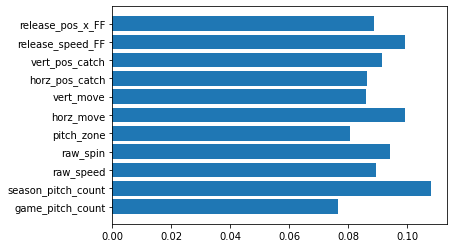

In [ ]:
# Plot feature importances from Ranfom Forest classifier
cols = list(X_train.columns)
cols 

plt.barh(cols, clf.feature_importances_)

In [ ]:
# Put data into format suitable for xgboost
X, y = master_df.iloc[:,:-1],master_df.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set paramaters
#params = {"objective":"binary:logistic", 'learning_rate': .03, 'gamma':.1,
#                'max_depth': 5, 'min_child_weight':2, 'subsample':1,
#          'colsample_bytree': .9}

params = {"objective":"binary:logistic", 'learning_rate': .03, 'gamma':.1,
                'max_depth': 3, 'min_child_weight':3, 'subsample':1,
          'colsample_bytree': .9}

# Cross validation of xgboost
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=500,early_stopping_rounds=10,
                    metrics=['logloss'], as_pandas=True,
                    verbose_eval = True)


[0]	train-logloss:0.668082+3.6341e-05	test-logloss:0.668093+2.23954e-05
[1]	train-logloss:0.644457+3.59104e-05	test-logloss:0.64451+3.95502e-05
[2]	train-logloss:0.622241+5.47053e-05	test-logloss:0.622301+4.90329e-05
[3]	train-logloss:0.601233+0.000155495	test-logloss:0.601291+4.23504e-05
[4]	train-logloss:0.581363+0.000143458	test-logloss:0.581448+7.11821e-05
[5]	train-logloss:0.562497+0.000128704	test-logloss:0.56268+8.49405e-05
[6]	train-logloss:0.544707+0.000181491	test-logloss:0.54486+9.38521e-05
[7]	train-logloss:0.527728+0.00015698	test-logloss:0.527931+0.000114453
[8]	train-logloss:0.511651+0.000143778	test-logloss:0.511903+0.000122118
[9]	train-logloss:0.49638+0.000156768	test-logloss:0.496661+0.000125865
[10]	train-logloss:0.481881+0.000176943	test-logloss:0.482146+0.000139616
[11]	train-logloss:0.468058+0.000214019	test-logloss:0.468373+0.000142199
[12]	train-logloss:0.45488+0.000236587	test-logloss:0.45521+0.00015277
[13]	train-logloss:0.442332+0.000252133	test-logloss:0.44

In [ ]:
# Train full classifier with best paramters
xg_classifier = xgb.XGBClassifier(objective="binary:logistic", 
                learning_rate=0.03, gamma=.1,
                max_depth= 3, min_child_weight=3, n_estimators=210, subsample=1)
# Fit
xg_classifier.fit(X_train,y_train)

# Make predictions for positive class only
preds = xg_classifier.predict_proba(X_test)
preds = preds[:,1]

In [ ]:
preds

array([0.02910852, 0.04868817, 0.04898467, ..., 0.04797675, 0.03653064,
       0.05073239], dtype=float32)

In [ ]:
# Organize results, calculate brier score and mean predicted by class
results = pd.DataFrame({'predicted':preds, 'actual':y_test})
results.sort_values(by=['predicted'], ascending=False)
results['brier_score'] = (results['predicted'] - results['actual'])**2

results.groupby(['actual'])['predicted'].mean()



actual
0    0.040077
1    0.059155
Name: predicted, dtype: float32

In [ ]:
results['brier_score'].mean()

0.036947013872888526

In [ ]:
# View the features for a selected test case
X_test.loc[16981]

game_pitch_count              41.000000
season_pitch_count            76.000000
raw_speed                     77.400000
raw_spin                    2551.000000
pitch_zone                    13.000000
horz_move                     -1.540000
vert_move                     -0.460000
horz_pos_catch                -0.870000
vert_pos_catch                 0.210000
release_speed_FF              -0.013697
release_pos_x_FF               0.054410
InjuredThisSeasonAlready       0.000000
Name: 16981, dtype: float64

In [ ]:
results.sort_values(by=['predicted'], ascending=False).head(25)

predicted         0.049314
actual            1.000000
predictedClass    0.000000
Name: 11988, dtype: float64

In [ ]:
results.to_csv("results.csv")

In [ ]:
# Find the optimal threshold for imbalanced classes by trying every .01 in (0,1)
thresholds = np.arange(0, 1, 0.01).tolist()

for i in thresholds:
  temp_results = results
  temp_results['predictedClass'] = np.where(temp_results['predicted'] < i, 0, 1)
  print(i, ":", f1_score(temp_results['actual'], temp_results['predictedClass'], average='binary'))

#temp_results

0.0 : 0.07592093441150045
0.01 : 0.08187984496124032
0.02 : 0.08327174180832718
0.03 : 0.08964365256124722
0.04 : 0.11934361014420687
0.05 : 0.14888888888888888
0.06 : 0.16347826086956518
0.07 : 0.16352201257861637
0.08 : 0.1461187214611872
0.09 : 0.13774104683195593
0.1 : 0.1299638989169675
0.11 : 0.11914893617021279
0.12 : 0.09478672985781988
0.13 : 0.09
0.14 : 0.07291666666666667
0.15 : 0.0427807486631016
0.16 : 0.02209944751381215
0.17 : 0.02247191011235955
0.18 : 0.011428571428571427
0.19 : 0.011627906976744186
0.2 : 0.011627906976744186
0.21 : 0.011627906976744186
0.22 : 0.011695906432748537
0.23 : 0.011695906432748537
0.24 : 0.011695906432748537
0.25 : 0.011764705882352941
0.26 : 0.011764705882352941
0.27 : 0.011764705882352941
0.28 : 0.011764705882352941
0.29 : 0.011764705882352941
0.3 : 0.011764705882352941
0.31 : 0.011764705882352941
0.32 : 0.011764705882352941
0.33 : 0.011764705882352941
0.34 : 0.011764705882352941
0.35000000000000003 : 0.011764705882352941
0.36 : 0.0
0.37 :

In [ ]:
# Calculate confusion matrix best on the best threshold given in the last block

temp_results = results
temp_results['predictedClass'] = np.where(temp_results['predicted'] < .07, 0, 1)

print(classification_report(temp_results['actual'], temp_results['predictedClass']))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4114
           1       0.13      0.23      0.16       169

    accuracy                           0.91      4283
   macro avg       0.55      0.58      0.56      4283
weighted avg       0.93      0.91      0.92      4283



In [ ]:
temp_results.to_csv("temp_results.csv")

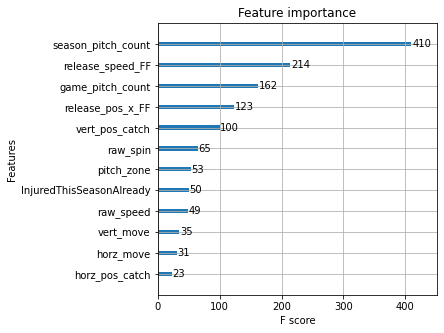

In [ ]:
# Feature importance of xgboost
xgb.plot_importance(xg_classifier)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

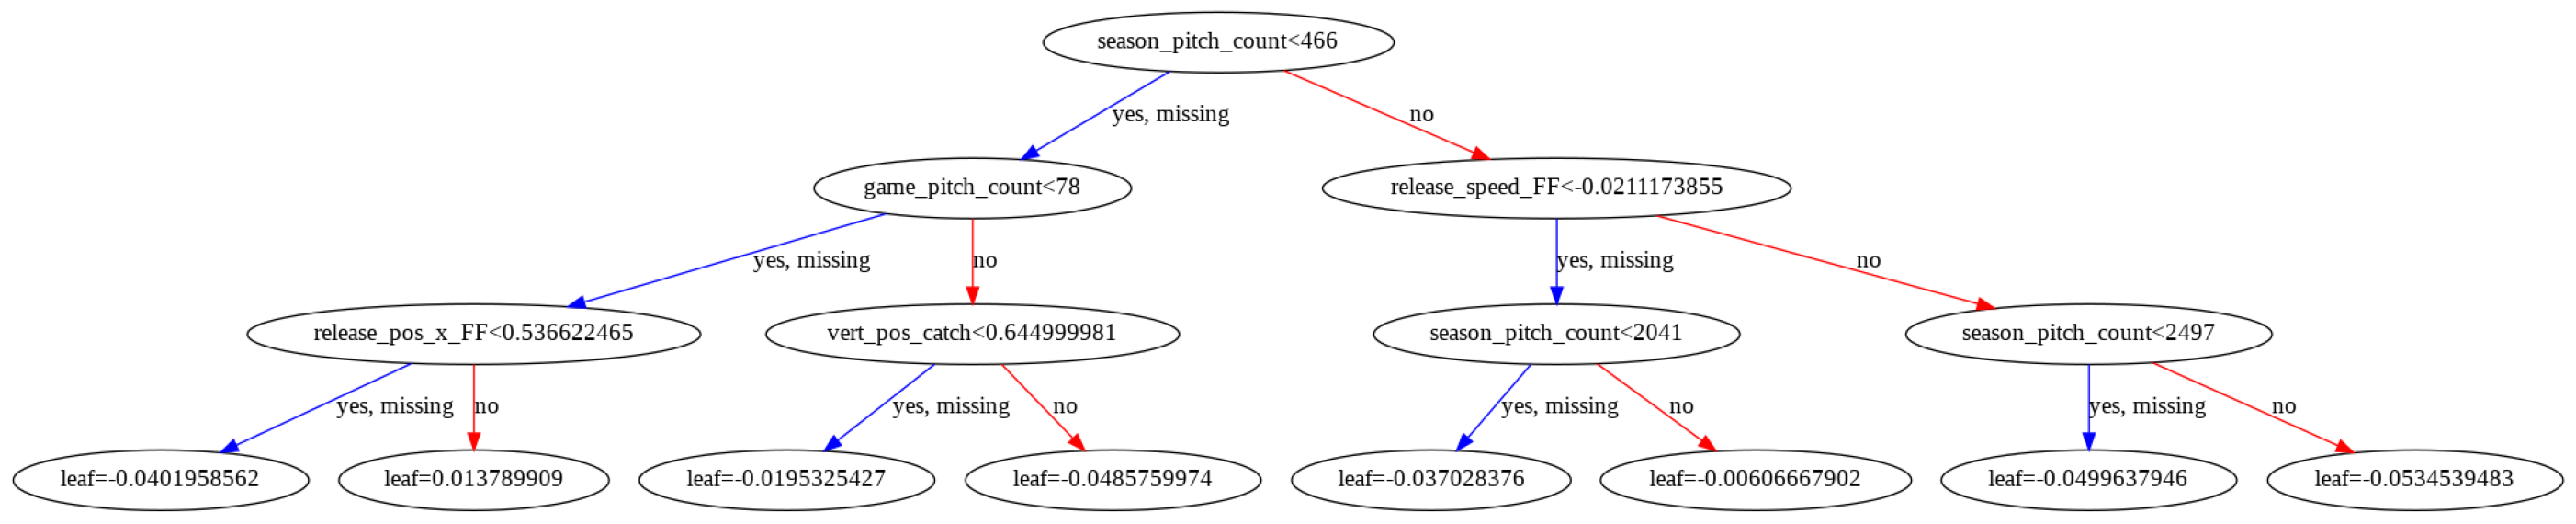

In [ ]:
# Plot a sample tree from the model
xgb.plot_tree(xg_classifier,num_trees=4)
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

In [ ]:
# Plot of predicted probabilities by class
fig = px.scatter(results, x="actual", y="predicted")
fig.show()

In [ ]:
# K-fold cross validation
for i in range(1,6):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  # Train full classifier with best paramters
  xg_classifier = xgb.XGBClassifier(objective="binary:logistic", 
                learning_rate=0.03, gamma=.1,
                max_depth= 3, min_child_weight=2, n_estimators=250, subsample=1)
  # Fit
  xg_classifier.fit(X_train,y_train)

  # Make predictions for positive class only
  preds = xg_classifier.predict_proba(X_test)
  preds = preds[:,1]  

  results = pd.DataFrame({'predicted':preds, 'actual':y_test})
  temp_results = results
  temp_results['predictedClass'] = np.where(temp_results['predicted'] < .06, 0, 1)
  print(classification_report(temp_results['actual'], temp_results['predictedClass']))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4121
           1       0.09      0.27      0.13       162

    accuracy                           0.87      4283
   macro avg       0.53      0.58      0.53      4283
weighted avg       0.94      0.87      0.90      4283

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4100
           1       0.10      0.23      0.14       183

    accuracy                           0.87      4283
   macro avg       0.53      0.57      0.53      4283
weighted avg       0.93      0.87      0.90      4283

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4104
           1       0.08      0.18      0.11       179

    accuracy                           0.88      4283
   macro avg       0.52      0.55      0.52      4283
weighted avg       0.93      0.88      0.90      4283

              preci

In [ ]:
# Shap analysis of important features
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xg_classifier)
shap_values = explainer.shap_values(X)

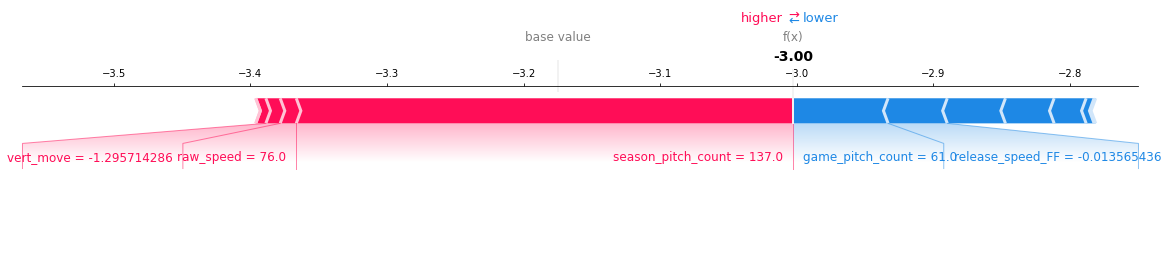

In [ ]:
# Visual for one test case
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[11987,:], matplotlib=True )

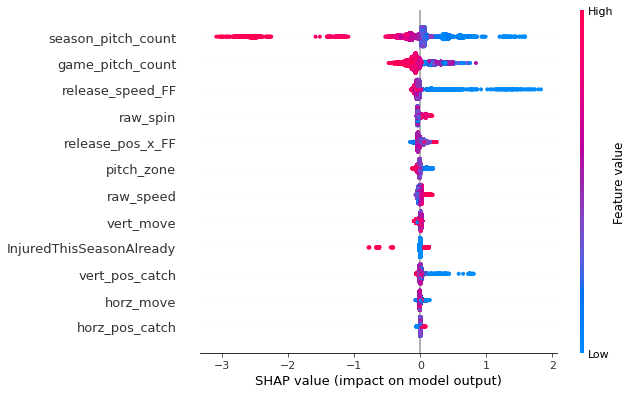

In [ ]:
# Feature importance overall
shap.summary_plot(shap_values, X)